<a href="https://colab.research.google.com/github/carlosarreguib/PROYECTO_1/blob/Carlos_Arregui/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Importamos las librerias pandas y matplot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Creamos el dataframe con el archivo csv de Kaggle
df = pd.read_csv("/content/Barcelona_Fotocasa_HousingPrices.csv")
df

,Unnamed: 0,price,rooms,bathroom,lift,terrace,square_meters,real_state,neighborhood,square_meters_price
0,0,750,3,1,True,False,60,flat,Horta- Guinardo,12.500000
1,1,770,2,1,True,False,59,flat,Sant Andreu,13.050847
2,2,1300,1,1,True,True,30,flat,Gràcia,43.333333
3,3,2800,1,1,True,True,70,flat,Ciutat Vella,40.000000
4,4,720,2,1,True,False,44,flat,Sant Andreu,16.363636
...,...,...,...,...,...,...,...,...,...,...
8183,8183,1075,2,2,False,False,65,flat,Gràcia,16.538462
8184,8184,1500,3,2,True,False,110,flat,Eixample,13.636364
8185,8185,1500,2,2,True,True,90,flat,Sarria-Sant Gervasi,16.666667
8186,8186,1500,3,2,True,False,110,flat,Eixample,13.636364


Viendo la tabla, vemos que hay 9 columnas que contienen la siguiente información (por orden):
1. Precio
2. Número de habitaciones
3. Número de baños
4. Ascensor (TRUE / FALSE)
5. Terraza (TRUE / FALSE)
6. Metros cuadrados
7. Tipo de vivienda (apartment / attic / flat / study)
8. Barrio (10 distintos)
9. Precio por metro cuadrado

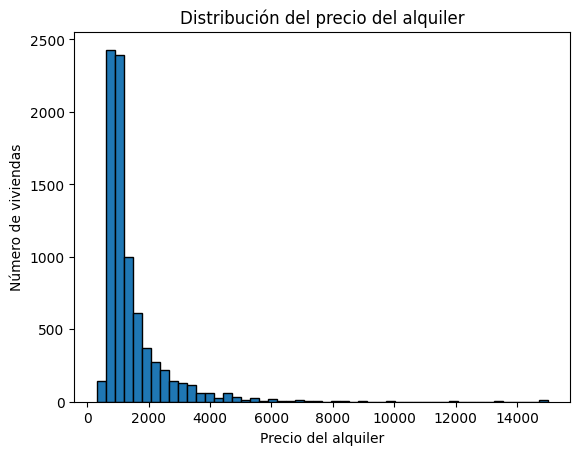

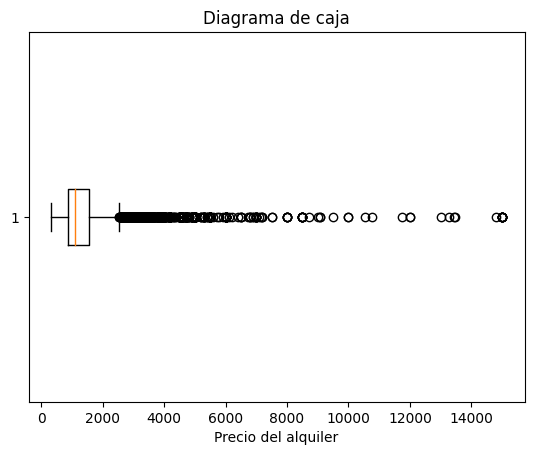

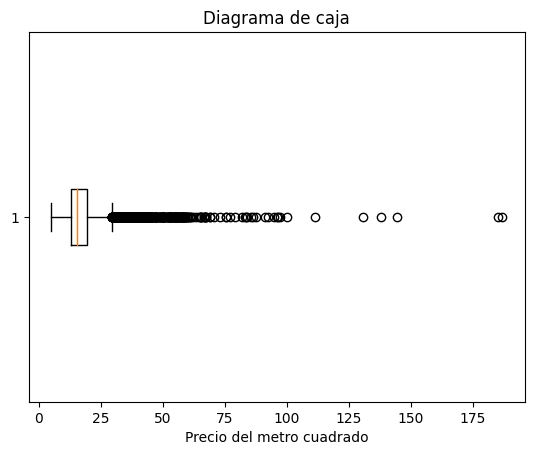

In [119]:
# Representamos la distribución del precio del alquiler para ver qué valores son más comunes
plt.hist(df['price'], bins=50, edgecolor='black')
plt.title('Distribución del precio del alquiler')
plt.xlabel('Precio del alquiler')
plt.ylabel('Número de viviendas')
plt.show()

plt.boxplot(df['price'], vert=False)
plt.title('Diagrama de caja')
plt.xlabel('Precio del alquiler')
plt.show()

plt.boxplot(df['square_meters_price'], vert=False)
plt.title('Diagrama de caja')
plt.xlabel('Precio del metro cuadrado')
plt.show()

Con estos gráficos vemos que hay muchos precios atípicos a la derecha del gráfico de caja. Esto quiere decir que hay precios elevados que afectarán a los cálculos de ajuste y por tanto, hay que eliminarlos.

Por definición, los puntos atípicos superiores son aquellos que sobrepasan el Q3 en 1.5 veces el rango intercuartílico (IQR). Por el contrario, los puntos atípicos inferiores son aquellos que se situan 1.5*IQR por debajo del Q1. Todos estos valores, hay que eliminarlos del dataframe para que afecten lo menos posible al ajuste. En nuestro caso, únicamente hay atípicos superiores.

In [117]:
# Calculamos el Q1, Q3, el IQR y el límite superior
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
LS = Q3 + 1.5 * IQR

# Filtramos los precios del dataframe acorde con el límite superior calculado
df_filtrado_1 = df[df['price'] <= LS]

# Comparamos los datos originales con los filtrados para ver qué barrios han sido más afectados
# Primero agrupamos por barrio y contamos el número de viviendas antes y después del filtrado
df_grupo_barrio = df.groupby('neighborhood')['Unnamed: 0'].count()
df_grupo_barrio_filtrado = df_filtrado_1.groupby('neighborhood')['Unnamed: 0'].count()

# Unimos los dos dataframes y calculamos la diferencia de viviendas
df_resultado_1 = pd.merge(df_grupo_barrio, df_grupo_barrio_filtrado, on='neighborhood', how='left')
df_resultado_1['Diferencia'] = df_resultado_1['Unnamed: 0_x'] - df_resultado_1['Unnamed: 0_y']
df_resultado_1['Variación %'] = round(df_resultado_1['Diferencia'] / df_resultado_1['Unnamed: 0_x'] * 100, 2)

# Renombramos columnas para facilitar la lectura de resultados
total_1 = df_resultado_1['Diferencia'].sum()
print(f'Con el filtrado según los atípicos del precio se han eliminado {total_1} viviendas')

df_resultado_1.rename(columns={'Unnamed: 0_x': 'Viviendas totales','Unnamed: 0_y': 'Viviendas filtradas'}, inplace=True)
df_resultado_1

Con el filtrado según los atípicos del precio se han eliminado 807 viviendas


,Viviendas totales,Viviendas filtradas,Diferencia,Variación %
neighborhood,,,,
Ciutat Vella,1365,1299,66,4.84
Eixample,2401,2129,272,11.33
Gràcia,688,655,33,4.80
Horta- Guinardo,315,314,1,0.32
Les Corts,524,440,84,16.03
Nou Barris,114,114,0,0.00
Sant Andreu,178,178,0,0.00
Sant Martí,617,569,48,7.78
Sants-Montjuïc,590,576,14,2.37


Con este análisis vemos que la zona más afectada por la reducción de los datos a aquellas viviendas que se encuentren por debajo del percentil 98 en cuanto al precio, es el barrio de Sarrià-Sant Gervasi, con una reducción de 12.20% de viviendas respecto al total de su conteo, el barrio de Eixample con 6.67 y el barrio de Sant Martí con 6.15%.

Esto será importante porque a mayor número de viviendas eliminadas con el filtrado, mayor será el error acumulado por el modelo en ese barrio.

In [120]:
# Calculamos el Q1, Q3, el IQR y el límite superior
Q1 = df['square_meters_price'].quantile(0.25)
Q3 = df['square_meters_price'].quantile(0.75)
IQR = Q3 - Q1
LS = Q3 + 1.5 * IQR

# Filtramos los precios del dataframe acorde con el límite superior calculado
df_filtrado_2 = df[df['square_meters_price'] <= LS]

# Comparamos los datos originales con los filtrados para ver qué barrios han sido más afectados
# Primero agrupamos por barrio y contamos el número de viviendas antes y después del filtrado
df_grupo_barrio = df.groupby('neighborhood')['Unnamed: 0'].count()
df_grupo_barrio_filtrado = df_filtrado_2.groupby('neighborhood')['Unnamed: 0'].count()

# Unimos los dos dataframes y calculamos la diferencia de viviendas
df_resultado_2 = pd.merge(df_grupo_barrio, df_grupo_barrio_filtrado, on='neighborhood', how='left')
df_resultado_2['Diferencia'] = df_resultado_2['Unnamed: 0_x'] - df_resultado_2['Unnamed: 0_y']
df_resultado_2['Variación %'] = round(df_resultado_2['Diferencia'] / df_resultado_2['Unnamed: 0_x'] * 100, 2)

# Renombramos columnas para facilitar la lectura de resultados
total_2 = df_resultado_2['Diferencia'].sum()
print(f'Con el filtrado con los atípicos del precio por metro cuadrado se han eliminado {total_2} viviendas')

df_resultado_2.rename(columns={'Unnamed: 0_x': 'Viviendas totales','Unnamed: 0_y': 'Viviendas filtradas'}, inplace=True)
df_resultado_2

Con el filtrado con los atípicos del precio por metro cuadrado se han eliminado 589 viviendas


,Viviendas totales,Viviendas filtradas,Diferencia,Variación %
neighborhood,,,,
Ciutat Vella,1365,1244,121,8.86
Eixample,2401,2167,234,9.75
Gràcia,688,638,50,7.27
Horta- Guinardo,315,311,4,1.27
Les Corts,524,513,11,2.10
Nou Barris,114,114,0,0.00
Sant Andreu,178,176,2,1.12
Sant Martí,617,578,39,6.32
Sants-Montjuïc,590,562,28,4.75


Después de analizar qué variable descartaba más viviendas, se concluye que es mejor realizar el filtrado por el precio del metro cuadrado en vez del precio total de la vivienda. Filtrando por el precio se eliminan 807 viviendas del total de la lista. En cambio si se hace por el precio del metro cuadrado, se eliminan 589. De este modo habrá más viviendas para entrenar el modelo

Coeficiente de correlación de Pearson entre el precio y los metros cuadrados:  0.8564
Coeficiente de correlación de Pearson entre el precio y los baños:  0.713
Coeficiente de correlación de Pearson entre el precio y el ascensor:  0.1692
Coeficiente de correlación de Pearson entre el precio y la terraza:  0.2362
Coeficiente de correlación de Pearson entre el precio y el precio por metro cuadrado:  0.2538


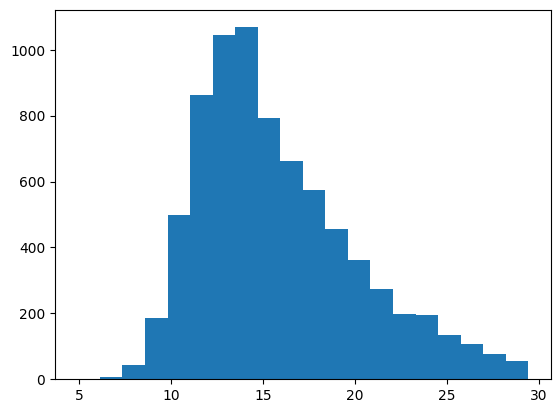

In [148]:
# Establecemos que df es de aquí en adelante el df del filtrado por el precio por el metro cuadrado
df = df_filtrado_2

# Analizamos la correlación del precio con otras variables del dataframe
corr_1 = df['price'].corr(df['square_meters'])
corr_2 = df['price'].corr(df['bathroom'])
corr_3 = df['price'].corr(df['lift'])
corr_4 = df['price'].corr(df['terrace'])
corr_5 = df['price'].corr(df['square_meters_price'])

print("Coeficiente de correlación de Pearson entre el precio y los metros cuadrados: ", round(corr_1, 4))
print("Coeficiente de correlación de Pearson entre el precio y los baños: ", round(corr_2, 4))
print("Coeficiente de correlación de Pearson entre el precio y el ascensor: ", round(corr_3, 4))
print("Coeficiente de correlación de Pearson entre el precio y la terraza: ", round(corr_4, 4))
print("Coeficiente de correlación de Pearson entre el precio y el precio por metro cuadrado: ", round(corr_5, 4))

plt.hist(df['square_meters_price'], bins=20)
plt.show()